In [21]:
import numpy as np
import pandas as pd

import re

from sklearn.model_selection import train_test_split

In [22]:
data = pd.read_csv('diabetes.csv')
data = data[['Diabetes_binary','HighBP','HighChol','Smoker', 'HvyAlcoholConsump','DiffWalk']]
data.rename(columns={"Diabetes_binary":"D","HighBP":"P", "HighChol":"C", "HvyAlcoholConsump":"A", "DiffWalk":"DC", "Smoker":"F"}, inplace=True)

In [23]:
data

,D,P,C,F,A,DC
0,0.0,1.0,1.0,1.0,0.0,1.0
1,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,1.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...
253675,0.0,1.0,1.0,0.0,0.0,0.0
253676,1.0,1.0,1.0,0.0,0.0,1.0
253677,0.0,0.0,0.0,0.0,0.0,0.0
253678,0.0,1.0,0.0,0.0,0.0,0.0


# Dividimos los datos en datos de entrenamiento y prueba 


In [79]:
entrenamiento, prueba = train_test_split(data, test_size=0.2, random_state=42)
# Verificar la distribución de la variable objetivo en ambos conjuntos
print("Distribución en entrenamiento:")
print(entrenamiento['D'].value_counts(normalize=True))
print("\nDistribución en prueba:")
print(prueba['D'].value_counts(normalize=True))
print(len(entrenamiento), "en entrenamiento")
print(len(prueba), "en prueba")

Distribución en entrenamiento:
D
0.0    0.860311
1.0    0.139689
Name: proportion, dtype: float64

Distribución en prueba:
D
0.0    0.86209
1.0    0.13791
Name: proportion, dtype: float64
202944 en entrenamiento
50736 en prueba


A : Alchoholico
F : Fumador
D : Diabetes
P : Presion Alta
DC : Dificultad al caminar
C : Colesterol Alto

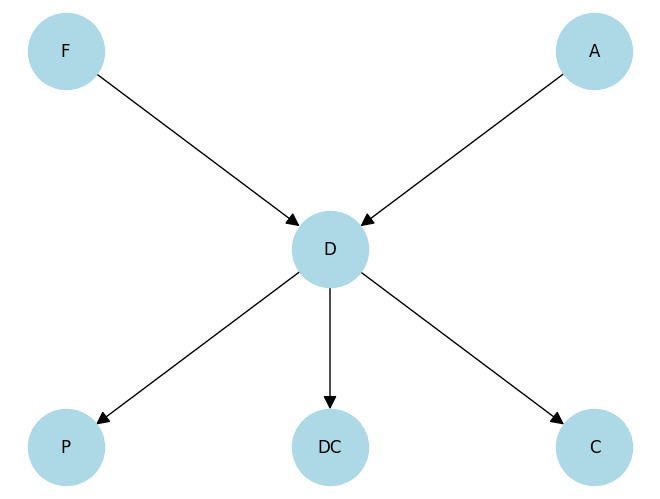

In [25]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()
G.add_edges_from([
    ('F','D'), 
    ('A','D'),  
    ('D','P'), 
    ('D','DC'),
    ('D','C')
])

# Posiciones: (x, y)
pos = {
    'F': (-.5, 2),
    'A': (.5, 2),
    'C': (.5, 0),
    'D': (0, 1),
    'P': (-.5, 0),
    'DC': (0, 0)
}

nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', arrowsize=20)
plt.show()


# Calculo de probabilidades con frecuencia

**Probabilidad de fumar y ser alcoholico**


$$
P(A) \approx \frac{\text{Número de veces que ocurre } A}{\text{Número total de observaciones}}
$$

 

In [26]:
probabilidad_fumar = data.F.sum()/len(entrenamiento)
probabilidad_alcoholico = data.A.sum()/len(entrenamiento)

In [27]:
print("Probailidad fumar", np.round(probabilidad_fumar,4))
print("Probailidad alcoholico", np.round(probabilidad_alcoholico,4))



Probailidad fumar 0.554
Probailidad alcoholico 0.0702


**Probabilidad de diabetes dado fumar y ser alcoholico**

Datos que cumplen las condiciones de la tabla

In [28]:
fumar_T_alcholico_T = entrenamiento.loc[(entrenamiento.F == 1.0) & (entrenamiento.A == 1.0)]
fumar_T_alcholico_F = entrenamiento.loc[(entrenamiento.F == 1.0) & (entrenamiento.A == 0)]
fumar_F_alcholico_T = entrenamiento.loc[(entrenamiento.F == 0) & (entrenamiento.A == 1.0)]
fumar_F_alcholico_F = entrenamiento.loc[(entrenamiento.F == 0) & (entrenamiento.A == 0)]

**Probabilidad de cada combinación dada su frecuencia en los datos**

In [29]:
probabilidad_diabetes_fumar_T_alcholico_T = fumar_T_alcholico_T.D.sum()/len(fumar_T_alcholico_T)
probabilidad_diabetes_fumar_T_alcholico_F = fumar_T_alcholico_F.D.sum()/len(fumar_T_alcholico_F)
probabilidad_diabetes_fumar_F_alcholico_T = fumar_F_alcholico_T.D.sum()/len(fumar_F_alcholico_T)
probabilidad_diabetes_fumar_F_alcholico_F = fumar_F_alcholico_F.D.sum()/len(fumar_F_alcholico_F)



In [30]:
print("F  A  | P(D)")
print("--------------")
print("T  T  |",np.round(probabilidad_diabetes_fumar_T_alcholico_T,4))
print("T  F  |",np.round(probabilidad_diabetes_fumar_T_alcholico_F,4))
print("F  T  |",np.round(probabilidad_diabetes_fumar_F_alcholico_T,4))
print("F  F  |",np.round(probabilidad_diabetes_fumar_F_alcholico_F,4))



F  A  | P(D)
--------------
T  T  | 0.0683
T  F  | 0.1725
F  T  | 0.0454
F  F  | 0.1232


**Calculo de la probabilidad total de tener diabetes**
Es decir, todas las combinaciones en las que puede pasar.

In [31]:
probabilidad_diabetes = probabilidad_diabetes_fumar_T_alcholico_T * probabilidad_fumar * probabilidad_alcoholico + \
                        probabilidad_diabetes_fumar_T_alcholico_F * probabilidad_fumar * (1 - probabilidad_alcoholico) + \
                        probabilidad_diabetes_fumar_F_alcholico_T * (1 - probabilidad_fumar) * probabilidad_alcoholico + \
                        probabilidad_diabetes_fumar_F_alcholico_F * (1 - probabilidad_fumar) * (1 - probabilidad_alcoholico) 
                        
                        

In [39]:
print("Probabilidad diabetes", np.round(probabilidad_diabetes,4))

Probabilidad diabetes 0.144


**Probabilidad de los sintomas dado la diabetes**



In [33]:
diabetes_T = data.loc[(data.D == 1.0)]
diabetes_F = data.loc[(data.D == 0)]

**Probabilidades condicionales dadas las frecuencias**



In [34]:
probabilidad_diabetes_T_presion_T = diabetes_T.P.sum()/len(diabetes_T)
probabilidad_diabetes_F_presion_T = diabetes_F.P.sum()/len(diabetes_F)

probabilidad_diabetes_T_colesterol_T = diabetes_T.C.sum()/len(diabetes_T)
probabilidad_diabetes_F_colesterol_T = diabetes_F.C.sum()/len(diabetes_F)

probabilidad_diabetes_T_diffcaminar_T = diabetes_T.DC.sum()/len(diabetes_T)
probabilidad_diabetes_F_diffcaminar_T = diabetes_F.DC.sum()/len(diabetes_F)



In [35]:
print("D  |  P(P)  |  P(C)  |  P(DC) ")
print("------------------------------")
print("T  |",np.round(probabilidad_diabetes_T_presion_T,4),'|',np.round(probabilidad_diabetes_T_colesterol_T,4),'|',np.round(probabilidad_diabetes_T_diffcaminar_T,4))
print("F  |",np.round(probabilidad_diabetes_F_presion_T,4),'|',np.round(probabilidad_diabetes_F_colesterol_T,4),'|',np.round(probabilidad_diabetes_F_diffcaminar_T,4))




D  |  P(P)  |  P(C)  |  P(DC) 
------------------------------
T  | 0.7527 | 0.6701 | 0.3712
F  | 0.3766 | 0.3843 | 0.1354


In [36]:
probabilidad_presion = probabilidad_diabetes_T_presion_T * probabilidad_diabetes + probabilidad_diabetes_F_presion_T * (1 - probabilidad_diabetes)
probabilidad_colesterol = probabilidad_diabetes_T_colesterol_T * probabilidad_diabetes + probabilidad_diabetes_F_colesterol_T * (1 - probabilidad_diabetes)
probabilidad_diffcaminar = probabilidad_diabetes_T_diffcaminar_T * probabilidad_diabetes + probabilidad_diabetes_F_diffcaminar_T * (1 - probabilidad_diabetes)



In [ ]:
print("Probabilidad presion alta", np.round(probabilidad_presion,4))
print("Probabilidad colesterol alto", np.round(probabilidad_colesterol,4))
print("Probabilidad dificultad para caminar", np.round(probabilidad_diffcaminar,4))


Probabilidad presion alta 0.4308
Probabilidad colesterol alto 0.4255
Probabilidad dificultad para caminar 0.1693


# Calculo del error de diagnóstico 

**Probabilidad de fumar y ser alcoholico**


$$
P(D \mid A, F, C, P, DC ) = \frac{P(D, A, F, C, P, DC)}{P(A,F, C, P,DC)} = \frac{P(D\mid A , F) P(C \mid D )P(P \mid D )P(DC \mid D )P(A)P(F)}{P(A)P(F)P(C)P(P)P(DC)} 
$$

$$
= \frac{P(D\mid A , F) P(C \mid D )P(P \mid D )P(DC \mid D )}{P(C)P(P)P(DC)}
$$

In [86]:
p_D_dado_F_A = {
    # (Diabetes, Fumar, Alcoholico)
    (1,1,1) : probabilidad_diabetes_fumar_T_alcholico_T,
    (0,1,1) : 1 - probabilidad_diabetes_fumar_T_alcholico_T,
    
    (1,1,0) : probabilidad_diabetes_fumar_T_alcholico_F,
    (0,1,0) : 1- probabilidad_diabetes_fumar_T_alcholico_F,
    
    (1,0,1) : probabilidad_diabetes_fumar_F_alcholico_T,
    (0,0,1) : 1 - probabilidad_diabetes_fumar_F_alcholico_T,
    
    (1,0,0) : probabilidad_diabetes_fumar_F_alcholico_F,
    (0,0,0) : 1 - probabilidad_diabetes_fumar_F_alcholico_F
}

p_C_dado_D = {
    # (Diabetes, Colesterol)
    (1,1) : probabilidad_diabetes_T_colesterol_T,
    (1,0) : 1 - probabilidad_diabetes_T_colesterol_T,
    (0,1) : probabilidad_diabetes_F_colesterol_T,
    (0,0) : 1 - probabilidad_diabetes_F_colesterol_T
}

p_C_dado_P = {
    # (Diabetes, Presion alta)
    (1,1) : probabilidad_diabetes_T_presion_T,
    (1,0) : 1 - probabilidad_diabetes_T_presion_T,
    (0,1) : probabilidad_diabetes_F_presion_T,
    (0,0) : 1 - probabilidad_diabetes_F_presion_T
}

p_C_dado_DC = {
    # (Diabetes, Dificuldad Caminar)
    (1,1) : probabilidad_diabetes_T_diffcaminar_T,
    (1,0) : 1 - probabilidad_diabetes_T_diffcaminar_T,
    (0,1) : probabilidad_diabetes_F_diffcaminar_T,
    (0,0) : 1 - probabilidad_diabetes_F_diffcaminar_T
}


probabilidad_fumar_vector = [1-probabilidad_fumar, probabilidad_fumar]
probabilidad_alcoholico_vector = [1-probabilidad_alcoholico, probabilidad_alcoholico]

probabilidad_diabetes_vector = [1-probabilidad_diabetes, probabilidad_diabetes]

probabilidad_presion_vector = [1-probabilidad_presion, probabilidad_presion]
probabilidad_colesterol_vector = [1-probabilidad_colesterol, probabilidad_colesterol]
probabilidad_diffcaminar_vector = [1-probabilidad_diffcaminar, probabilidad_diffcaminar]

y_real = []
y_pred = []
# Iterar en las filas del dataframe de prueba
for index, row in prueba.iterrows():
    F = int(row['F'])
    A = int(row['A'])
    D = int(row['D'])
    P = int(row['P'])
    C = int(row['C'])
    DC = int(row['DC'])
    
    y_real.append(D)
    
    resultado_provisional = []
    for posible_D in [0,1]:
        
        total = (p_D_dado_F_A[(posible_D,F,A)] * p_C_dado_D[(posible_D,C)] * p_C_dado_P[(posible_D,P)] * p_C_dado_DC[(posible_D,DC)]) / (probabilidad_presion_vector[P] * probabilidad_colesterol_vector[C] * probabilidad_diffcaminar_vector[DC])
        resultado_provisional.append(total)

    # Predecir la clase con mayor probabilidad
    prediccion = np.argmax(resultado_provisional)
    y_pred.append(prediccion)

In [87]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Calculate accuracy
accuracy = accuracy_score(y_real, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_real, y_pred))

# Print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_real, y_pred))

Accuracy: 0.8512

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92     43739
           1       0.43      0.23      0.30      6997

    accuracy                           0.85     50736
   macro avg       0.66      0.59      0.61     50736
weighted avg       0.82      0.85      0.83     50736


Confusion Matrix:
[[41588  2151]
 [ 5396  1601]]
